In [10]:
import os
from glob import glob
from torch.utils.data import Dataset
import decord
from ultralytics import YOLO

In [4]:
# Manejando el dataset
TESTING = True

if TESTING:
    GROUPS = ["gg", "La bika me persigue"]
else:
    GROUPS = None

DATA_ROOT = "./data"

def get_video_files(data_root, groups_filter):
    video_paths = []

    for group in os.listdir(data_root):
        group_dir = os.path.join(data_root, group)

        if not os.path.isdir(group_dir):
            continue

        if groups_filter is not None and group not in groups_filter:
            continue

        sessions = glob(os.path.join(group_dir, "session_*", "screen.mkv"))
        video_paths.extend(sessions)

    return video_paths

videos = get_video_files(DATA_ROOT, GROUPS)

print("Videos encontrados:")
for v in videos:
    print(v)
print(f"Total: {len(videos)}")


Videos encontrados:
./data/gg/session_20251026_080319/screen.mkv
./data/gg/session_20251026_075801/screen.mkv
./data/gg/session_20251026_075012/screen.mkv
./data/gg/session_20251026_075620/screen.mkv
./data/gg/session_20251026_075727/screen.mkv
./data/gg/session_20251026_080105/screen.mkv
./data/gg/session_20251026_075348/screen.mkv
./data/gg/session_20251026_075325/screen.mkv
./data/gg/session_20251026_075905/screen.mkv
./data/gg/session_20251026_075518/screen.mkv
./data/gg/session_20251026_074331/screen.mkv
./data/gg/session_20251026_075058/screen.mkv
./data/gg/session_20251026_075453/screen.mkv
./data/gg/session_20251026_080235/screen.mkv
./data/gg/session_20251026_075949/screen.mkv
Total: 15


## Dataset

In [11]:
decord.bridge.set_bridge("torch")

class MKVDataset(Dataset):
    def __init__(self, video_paths):
        self.video_paths = video_paths

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        # Carga el video completo (podrías mejorar para frames específicos)
        vr = decord.VideoReader(video_path)
        frames = vr.get_batch(range(len(vr)))
        return frames

dataset = MKVDataset(videos)


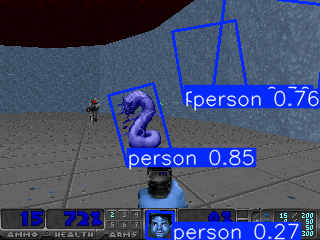

In [25]:
model = YOLO("/home/marcelino.maita/courses/deep_learning/lab2/try_4/runs/train/yolo11l_obb/weights/best.pt")

frame = dataset[0][822] # Fram 822 del primer video
frame_img = frame.byte().cpu().numpy()

results = model(frame_img, verbose = False, conf=0.20)
results[0].show()